In [ ]:
 !pip install transformers
!pip install torch

     |████████████████████████████████| 2.3MB 25.4MB/s 
     |████████████████████████████████| 3.3MB 41.6MB/s 
     |████████████████████████████████| 901kB 23.8MB/s 


# BERT(Bidirectional Encoder Representations From Transformers)
It's developed by people at Google AI Brain and is the current state of the art for NLP tasks

## Import

In [ ]:
import random
import re
import time
import datetime
import numpy as np
import pandas as pd
import os, json
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

## Train Data-Loader

In [ ]:
df= pd.read_csv('/content/tweet_dataset.csv')
train= pd.DataFrame()
train['text']= df['text']
train['Sentiment']=df['new_sentiment']
train=train.dropna()
train['Sentiment'] = train['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
train

,text,Sentiment
1,Layin n bed with a headache ughhhh...waitin o...,0
2,Funeral ceremony...gloomy friday...,0
3,wants to hang out with friends SOON!,2
4,We want to trade with someone who has Houston...,1
5,Re-pinging : why didn`t you go to prom? BC my ...,0
...,...,...
39994,Succesfully following Tayla!!,2
39996,Happy Mothers Day All my love,2
39997,Happy Mother`s Day to all the mommies out ther...,2
39998,WASSUP BEAUTIFUL!!! FOLLOW ME!! PEEP OUT MY ...,1


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


max_len = 0
for tweet in train['text']:
    
    # The following code is used to clean the tweets by removing URLs, accounts, quotation marks,etc
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)

    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))        #maximum length of input ids

print('Max sequence length: ', max_len)


Max sequence length:  110


In [ ]:
train

,text,Sentiment
1,Layin n bed with a headache ughhhh...waitin o...,0
2,Funeral ceremony...gloomy friday...,0
3,wants to hang out with friends SOON!,2
4,We want to trade with someone who has Houston...,1
5,Re-pinging : why didn`t you go to prom? BC my ...,0
...,...,...
39994,Succesfully following Tayla!!,2
39996,Happy Mothers Day All my love,2
39997,Happy Mother`s Day to all the mommies out ther...,2
39998,WASSUP BEAUTIFUL!!! FOLLOW ME!! PEEP OUT MY ...,1


In [ ]:
input_ids = []
attention_masks = []

for sent in train['text']:
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 110,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train['Sentiment'].tolist())


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)  #storing the input ids,masks and labels in dataset

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  #90-10 train-val split

In [ ]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),     #random sampling in training
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),    #sequential sampling in validation
            batch_size = batch_size 
        )


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,   
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
epochs = 4


total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 42
epochs=1

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.to(device)


training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        
        # Printing the progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch    40  of    882.    Elapsed: 0:00:21.
  Batch    80  of    882.    Elapsed: 0:00:43.
  Batch   120  of    882.    Elapsed: 0:01:06.
  Batch   160  of    882.    Elapsed: 0:01:29.
  Batch   200  of    882.    Elapsed: 0:01:53.
  Batch   240  of    882.    Elapsed: 0:02:17.
  Batch   280  of    882.    Elapsed: 0:02:40.
  Batch   320  of    882.    Elapsed: 0:03:04.
  Batch   360  of    882.    Elapsed: 0:03:28.
  Batch   400  of    882.    Elapsed: 0:03:51.
  Batch   440  of    882.    Elapsed: 0:04:15.
  Batch   480  of    882.    Elapsed: 0:04:38.
  Batch   520  of    882.    Elapsed: 0:05:02.
  Batch   560  of    882.    Elapsed: 0:05:26.
  Batch   600  of    882.    Elapsed: 0:05:49.
  Batch   640  of    882.    Elapsed: 0:06:13.
  Batch   680  of    882.    Elapsed: 0:06:37.
  Batch   720  of    882.    Elapsed: 0:07:00.
  Batch   760  of    882.    Elapsed: 0:07:24.
  Batch   800  of    882.    Elapsed: 0:07:47.
  Batch   840  of

In [ ]:
df_vax = pd.read_csv('/content/vaccination_all_tweets.csv')
df = pd.read_csv('/content/scraped_tweets.csv')
df_vax= df_vax.drop(['user_name','user_description','user_created','user_followers','user_friends','user_favourites','source','is_retweet', 'user_verified', 'retweets', 'favorites'],axis=1)
frames = [df_vax, df]
result = pd.concat(frames, ignore_index=True)
df_vax = result 
vax_tweets= df_vax['text']
df_vax

,id,user_location,date,text,hashtags
0,1340539111971516416,"La Crescenta-Montrose, CA",2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech']
1,1338158543359250433,"San Francisco, CA",2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN
2,1337858199140118533,Your Bed,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf..."
3,1337855739918835717,"Vancouver, BC - Canada",2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN
4,1337854064604966912,NaN,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']"
...,...,...,...,...,...
108553,8209,NaN,12/12/2020 1:49,@FergalBowers @rtenews COVID 19 VACCINES ARE N...,NaN
108554,8210,NaN,12/12/2020 7:35,@drivetimerte @RTERadio1 @SarahAMcInerney @rte...,NaN
108555,8211,NaN,12/12/2020 7:41,@BBCBreaking @MichealMartinTD @CMOIreland @rte...,NaN
108556,8212,NaN,12/12/2020 7:45,@PresidentIRL @merrionstreet @HSELive @merrion...,NaN


In [ ]:
input_ids = []
attention_masks = []

for sent in vax_tweets:
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 110,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
vax_dataset= TensorDataset(input_ids, attention_masks)

batch_size = 32

vax_dataloader = DataLoader(
            vax_dataset,  
            sampler = SequentialSampler(vax_tweets),     #Sequential Sampling
            batch_size = batch_size 
        )

In [ ]:
print('Predicting labels for {:,} vaccine tweets...'.format(len(input_ids)))

model.eval()

predictions = []

for batch in vax_dataloader:
 
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  
  logits=np.argmax(logits,axis=1)
  for i in range(len(logits)):
    predictions.append(logits[i])
print('    DONE.')


Predicting labels for 108,558 vaccine tweets...
    DONE.


In [ ]:
len(predictions)


108558

In [ ]:
df_vax['Sentiment'] = predictions
vax=df_vax

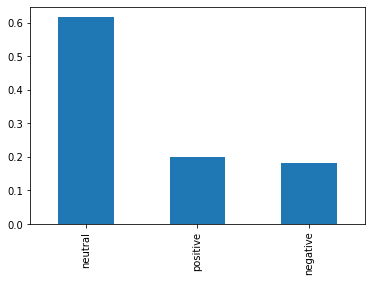

In [ ]:
vax['Sentiment']=vax['Sentiment'].map({0:'negative',1:'neutral',2:'positive'})
vax['Sentiment'].value_counts(normalize=True).plot.bar()


In [ ]:
vax['date'] = pd.to_datetime(vax['date'], errors='coerce').dt.date
vax['Sentiment'] = vax['Sentiment'].map({'negative':-1,'neutral':0,'positive':1})
vax.head()

,id,user_location,date,text,hashtags,Sentiment
0,1340539111971516416,"La Crescenta-Montrose, CA",2020-12-20,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0
1,1338158543359250433,"San Francisco, CA",2020-12-13,While the world has been on the wrong side of ...,NaN,1
2,1337858199140118533,Your Bed,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0
3,1337855739918835717,"Vancouver, BC - Canada",2020-12-12,"Facts are immutable, Senator, even when you're...",NaN,0
4,1337854064604966912,NaN,2020-12-12,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",0


In [ ]:
vax

,id,user_location,date,text,hashtags,Sentiment
0,1340539111971516416,"La Crescenta-Montrose, CA",2020-12-20,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0
1,1338158543359250433,"San Francisco, CA",2020-12-13,While the world has been on the wrong side of ...,NaN,1
2,1337858199140118533,Your Bed,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0
3,1337855739918835717,"Vancouver, BC - Canada",2020-12-12,"Facts are immutable, Senator, even when you're...",NaN,0
4,1337854064604966912,NaN,2020-12-12,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",0
...,...,...,...,...,...,...
108553,8209,NaN,2020-12-12,@FergalBowers @rtenews COVID 19 VACCINES ARE N...,NaN,-1
108554,8210,NaN,2020-12-12,@drivetimerte @RTERadio1 @SarahAMcInerney @rte...,NaN,-1
108555,8211,NaN,2020-12-12,@BBCBreaking @MichealMartinTD @CMOIreland @rte...,NaN,-1
108556,8212,NaN,2020-12-12,@PresidentIRL @merrionstreet @HSELive @merrion...,NaN,-1


In [ ]:
vax.to_excel("/content/BERT.xlsx")

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik','johnson']

vax_sentiment = pd.DataFrame()
vax_sentiment['Vaccine']=all_vax
sentiments=list()

In [ ]:
def time_variance(vacc) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        sentiments.append(vacc.Sentiment.mean())

    temp=pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

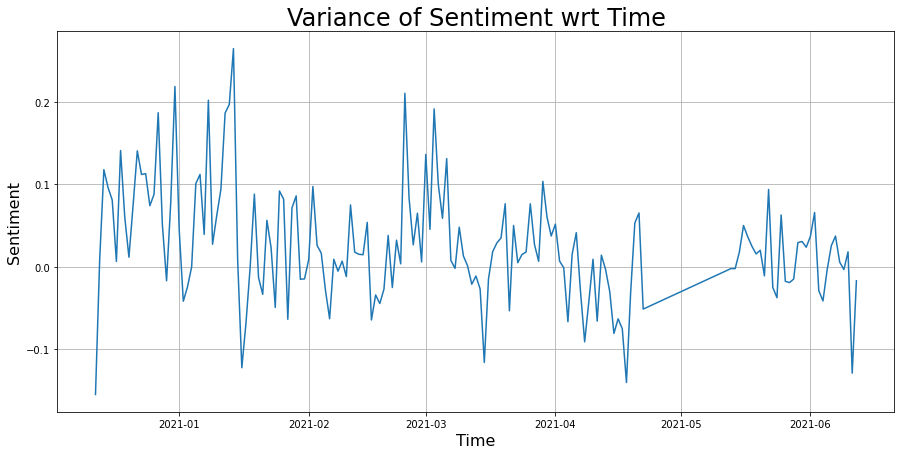

In [ ]:
time_variance('all')


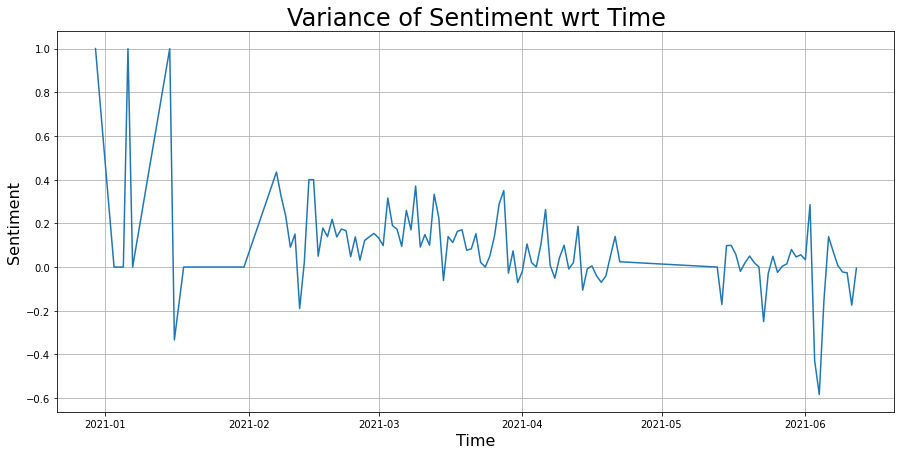

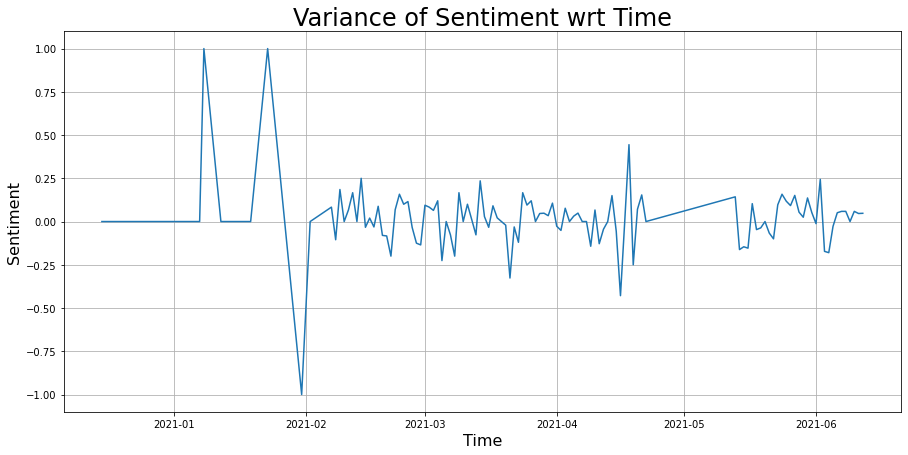

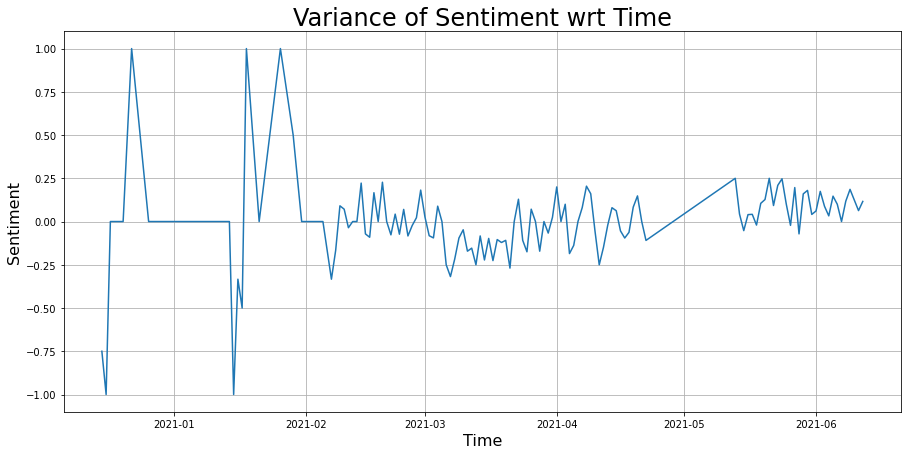

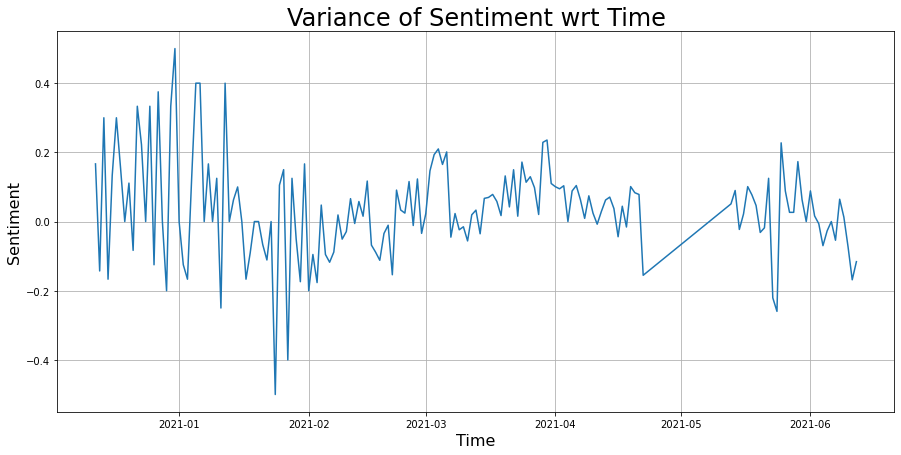

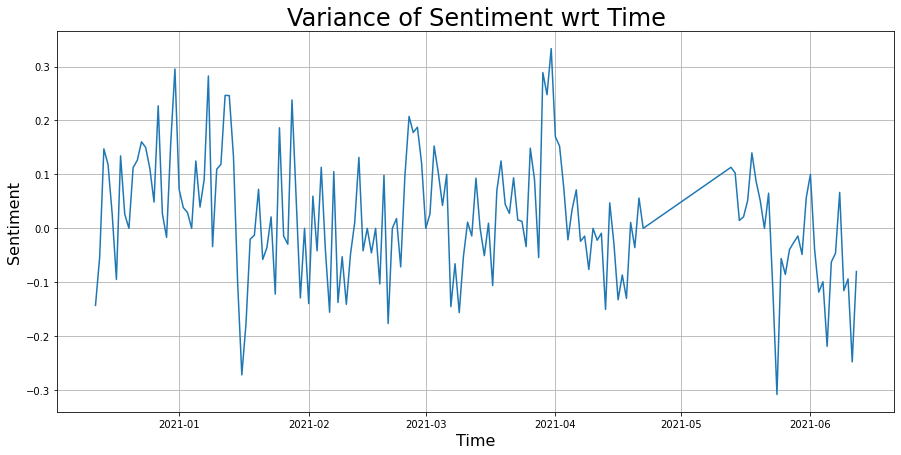

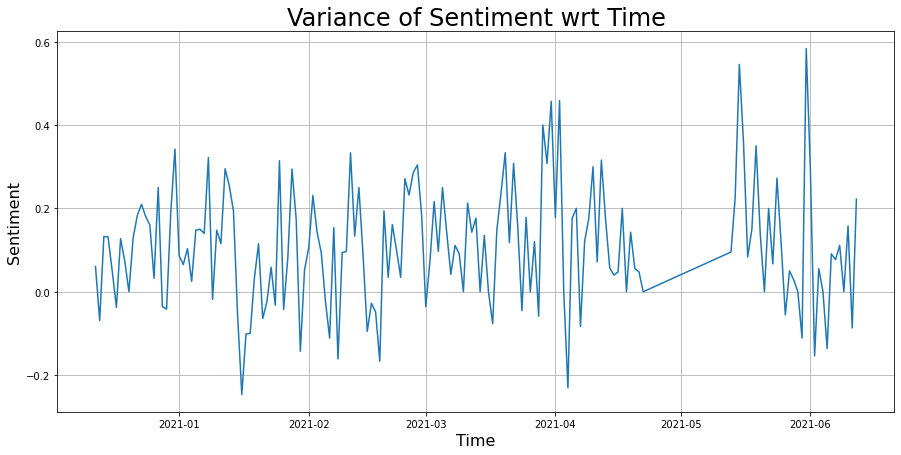

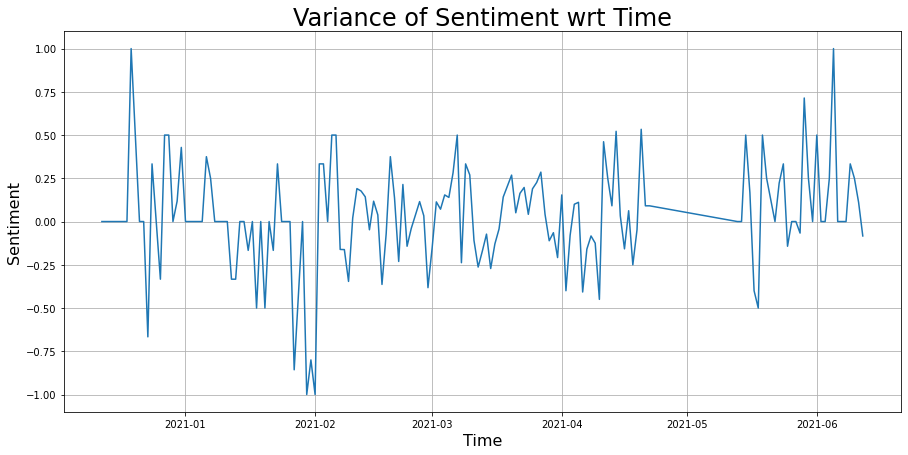

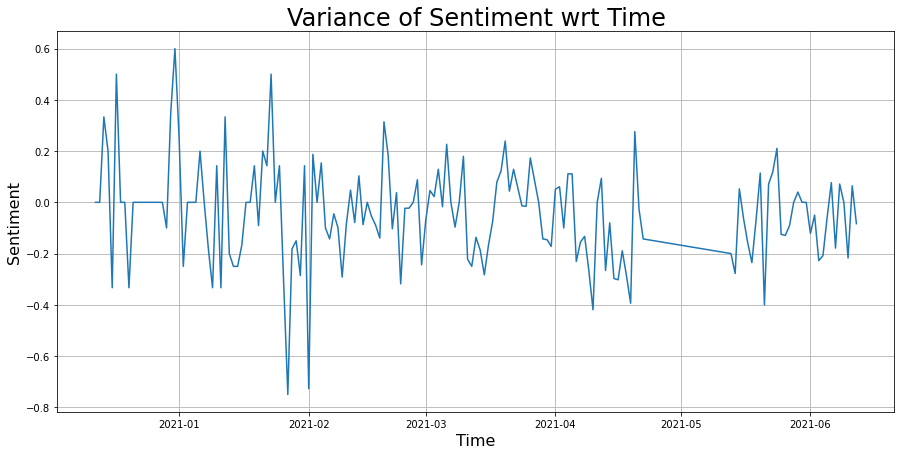

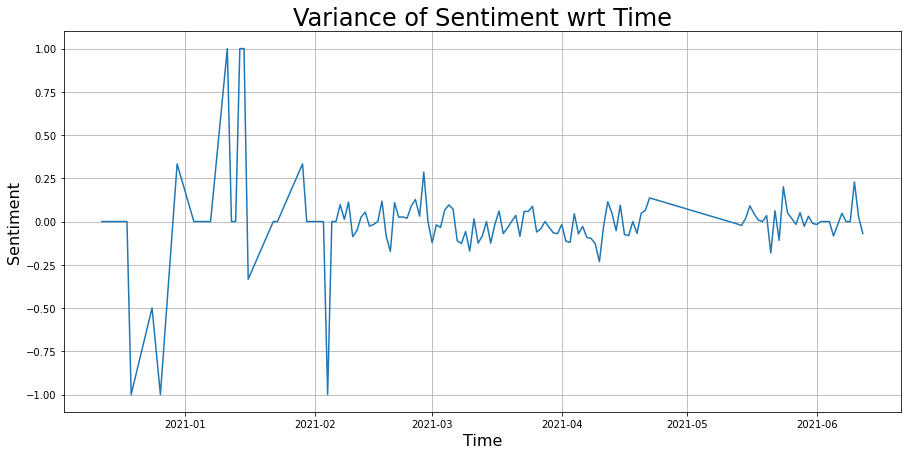

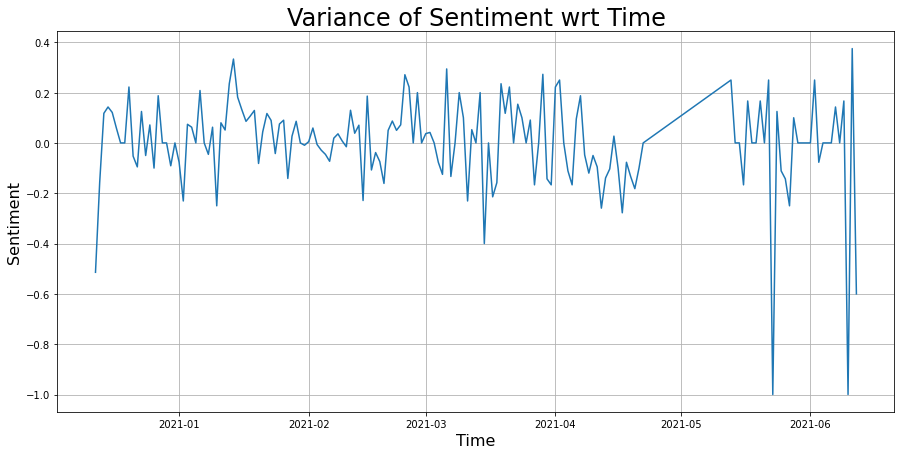

In [ ]:
time_variance('covaxin')
time_variance('sinopharm')
time_variance('sinovac')
time_variance('moderna')
time_variance('pfizer')
time_variance('biontech')
time_variance('oxford')
time_variance('astrazeneca')
time_variance('sputnik')
time_variance('johnson')


In [ ]:
sentiments


[0.057991967871485944,
 0.021438780371605525,
 0.023692970432739376,
 0.045258890885536376,
 0.015600877549362152,
 0.10781624957147755,
 0.014182257091128546,
 -0.055584148224395266,
 0.006552969839536252,
 0.04815595363540569]

Text(0.5, 1.0, 'Mean Sentiment of Vaccines')

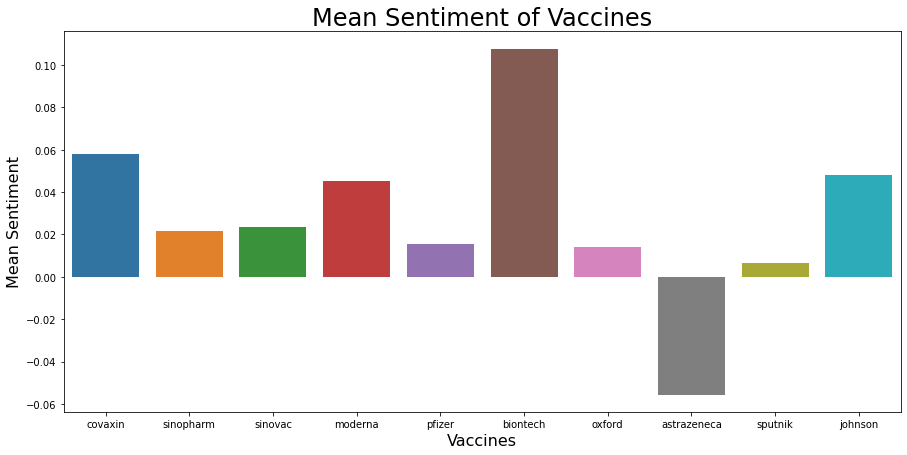

In [ ]:
vax_sentiment['Sentiment']=sentiments

fg,axs=plt.subplots(figsize=(15,7))
sns.barplot(ax=axs,x='Vaccine',y='Sentiment',data=vax_sentiment)
axs.set_xlabel("Vaccines",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Vaccines",size=24)

In [ ]:
def time_variance_vax_count(vacc, country, sento) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        vacc=vacc[vacc['user_location'].str.lower().str.contains(country)]
        sento.append(vacc.Sentiment.mean())

    temp=pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

def bar_graph_country(country):
  sento=[]
  for vaccine in all_vax:
    time_variance_vax_count(vaccine, country, sento)
  print(sento)
  vax_sentiment['Sentiment']=sento
  fg,axs=plt.subplots(figsize=(15,7))
  sns.barplot(ax=axs,x='Vaccine',y='Sentiment',data=vax_sentiment)
  axs.set_xlabel("Vaccines",size=16)
  axs.set_ylabel("Mean Sentiment",size=16)
  axs.set_title("Mean Sentiment of Vaccines".format(country),size=24)



In [ ]:
for country in countries:
  bar_graph_country(country)

In [ ]:
bar_graph_country('india')

In [ ]:
vax

,id,user_location,date,text,hashtags,Sentiment
0,1340539111971516416,"La Crescenta-Montrose, CA",2020-12-20,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0
1,1338158543359250433,"San Francisco, CA",2020-12-13,While the world has been on the wrong side of ...,NaN,1
2,1337858199140118533,Your Bed,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0
3,1337855739918835717,"Vancouver, BC - Canada",2020-12-12,"Facts are immutable, Senator, even when you're...",NaN,0
4,1337854064604966912,NaN,2020-12-12,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",0
...,...,...,...,...,...,...
108553,8209,NaN,2020-12-12,@FergalBowers @rtenews COVID 19 VACCINES ARE N...,NaN,-1
108554,8210,NaN,2020-12-12,@drivetimerte @RTERadio1 @SarahAMcInerney @rte...,NaN,-1
108555,8211,NaN,2020-12-12,@BBCBreaking @MichealMartinTD @CMOIreland @rte...,NaN,-1
108556,8212,NaN,2020-12-12,@PresidentIRL @merrionstreet @HSELive @merrion...,NaN,-1


In [ ]:
country_sentiment=pd.DataFrame()
countries=['india','usa','canada','germany','spain','pakistan','uk','brazil','russia','italy','australia','france','argentina','uae','israel','mexico','japan']
country_sentiment['countries']=countries
senti=list()
vax=vax.dropna()
for country in countries :
    senti.append(vax[vax['user_location'].str.lower().str.contains(country)].Sentiment.mean())
    
country_sentiment['Sentiment']=senti

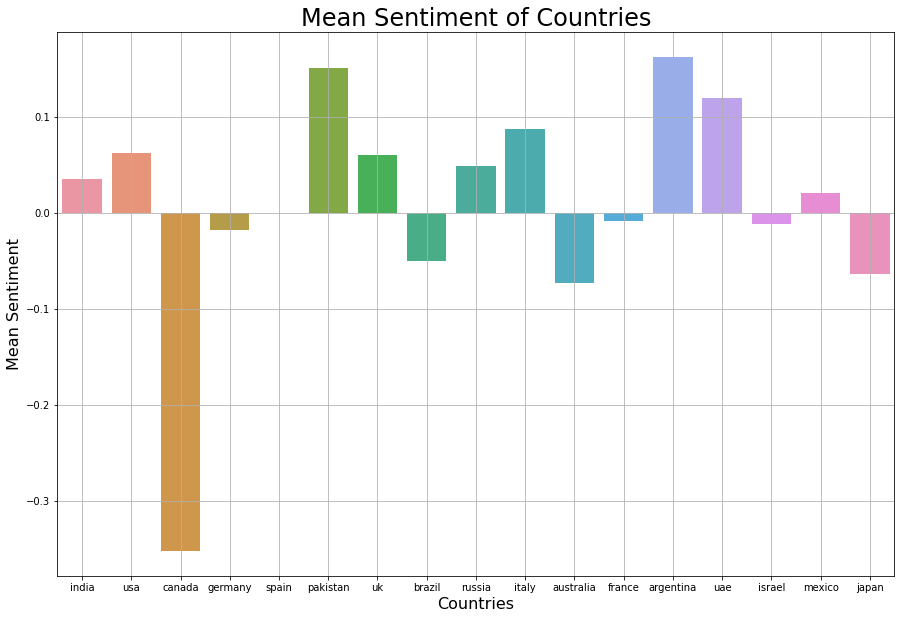

In [ ]:
fg,axs=plt.subplots(figsize=(15,10))
sns.barplot(ax=axs,x='countries',y='Sentiment',data=country_sentiment)
axs.set_xlabel("Countries",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Countries",size=24)
axs.grid()

In [ ]:
def time_variance_country(country) :
    count=vax[vax['user_location'].str.lower().str.contains(country)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

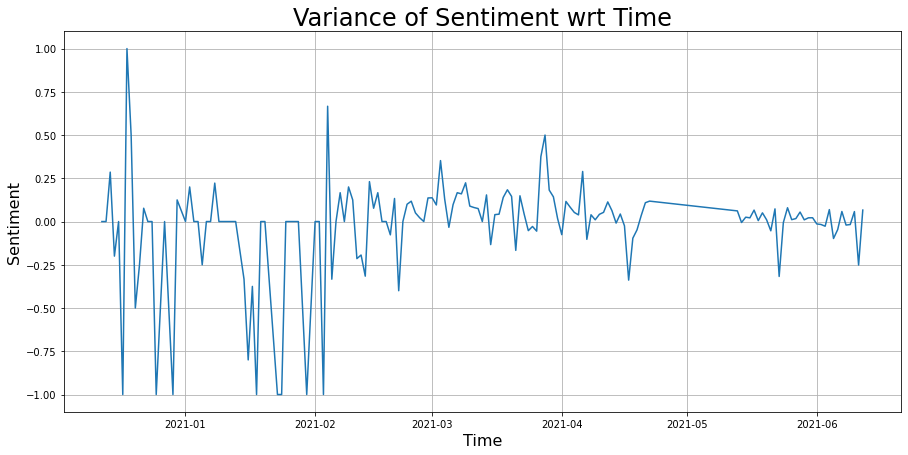

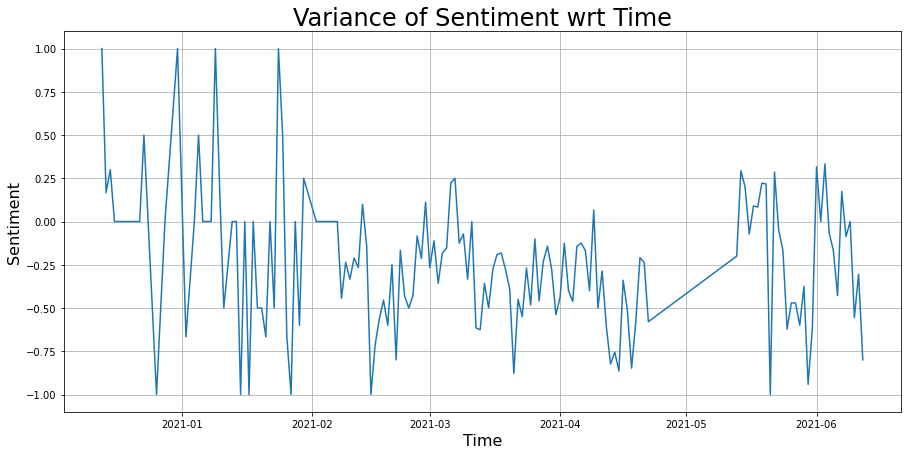

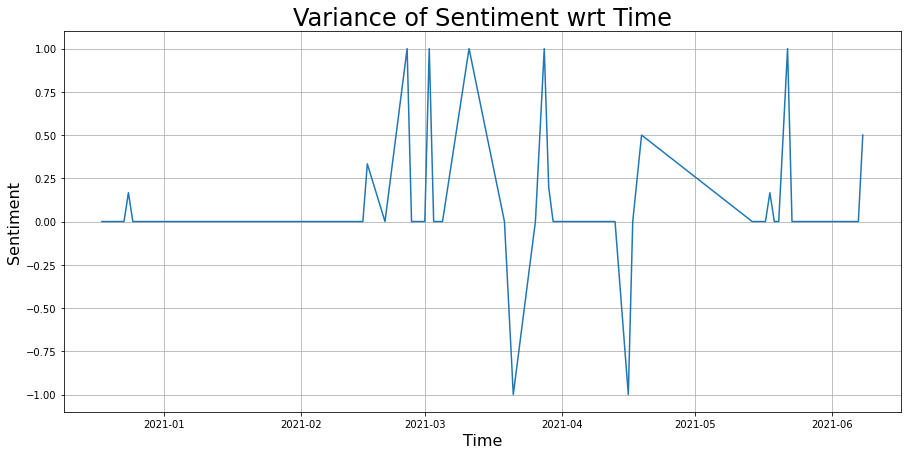

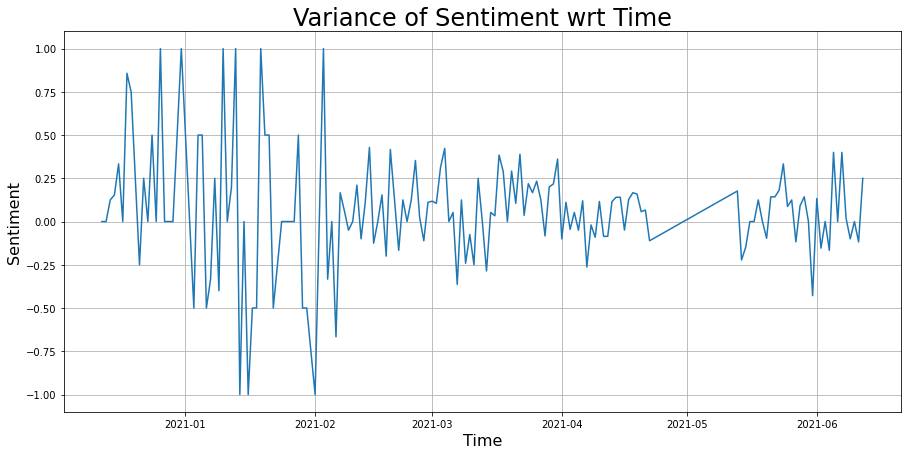

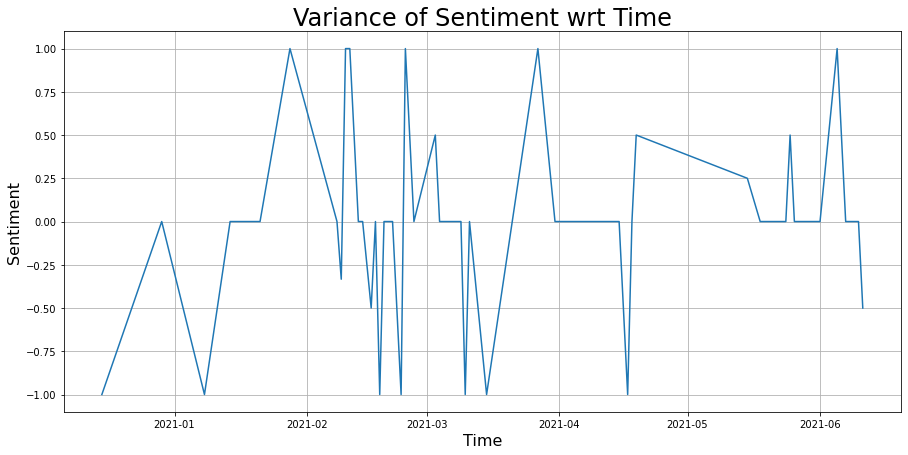

In [ ]:
time_variance_country('india')
time_variance_country('canada')
time_variance_country('uae')
time_variance_country('usa')
time_variance_country('spain')


In [ ]:
def time_variance_country_vaccine(country, vacc) :
    count=vax[vax['user_location'].str.lower().str.contains(country)]
    count=count[count['text'].str.lower().str.contains(vacc)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

In [ ]:
for vaccine in all_vax:
  for country in countries:
    time_variance_country_vaccine(country, vaccine)